In [199]:
import pandas as pd
import numpy as np
import random

# 1. Load Headers
try:
    df_orig = pd.read_csv('Survey on student expenses in University.csv')
    headers = df_orig.columns.tolist()
except FileNotFoundError:
    # Use your fallback headers
    headers = ['Timestamp', 'Gender', 'Year', 'Level', 'Field', 'Living', 'Scholarship', 'Loan', 'Allowance', 'Work', 'PartTimeIncome', 'Laptop', 'EatOut', 'ShopFreq', 'Track', 'Conscious', 'FoodWeekly', 'TransportWeekly', 'AccomPeriod', 'AccomCost', 'AcademicMonthly', 'InternetMonthly', 'EstimatedTotal']

# === 📊 CONFIGURATION: REAL DATA BOUNDARIES (FROM PILOT n=24) ===
REAL_MIN_ALLOWANCE = 0
REAL_MAX_ALLOWANCE = 1000

REAL_MIN_FOOD_WEEKLY = 6
REAL_MAX_FOOD_WEEKLY = 200

REAL_MIN_ACAD_MONTHLY = 0
REAL_MAX_ACAD_MONTHLY = 280

REAL_MIN_NET_MONTHLY = 0
REAL_MAX_NET_MONTHLY = 60

# ===============================================

data = []

# Choices (Same as before)
choices_gender = ["Male / Lelaki", "Female / Perempuan"]
choices_year = ["Year 1 / Tahun 1", "Year 2 / Tahun 2", "Year 3 / Tahun 3", "Year 4 or above / Tahun 4 atau ke atas"]
choices_level = ["Diploma", "Bachelor's Degree / Ijazah Sarjana Muda", "Master's / Sarjana", "PhD / Kedoktoran"]
choices_field = ["Computer Science / Sains Komputer", "Agriculture / Pertanian", "Others / Lain-lain"]
choices_living = ["With family / Tinggal bersama keluarga", "On-campus hostel / Asrama dalam kampus", "Off-campus rented house / Rumah sewa luar kampus"]
choices_yesno = ["Yes / Ya", "No / Tidak"]
choices_eat = ["Often (daily) / Kerap (setiap hari)", "Sometimes (3–6 times/week) / Kadang-kadang (3–6 kali/minggu)", "Rarely (0–2 times/week) / Jarang (0–2 kali/minggu)"]
choices_shop = ["Frequently / Kerap", "Occasionally / Sekali-sekala", "Rarely / Jarang"]

# Indices Helper
def get_col_index(keywords):
    for i, h in enumerate(headers):
        if all(k.lower() in h.lower() for k in keywords):
            return i
    return -1

idx_food = get_col_index(["food", "week"])
idx_transport = get_col_index(["transport", "week"])
idx_accom_period = get_col_index(["period", "accommodation"])
idx_accom_cost = get_col_index(["pay", "accommodation", "RM"])
idx_academic = get_col_index(["academic", "materials"])
idx_internet = get_col_index(["internet", "phone"])
idx_total_est = get_col_index(["estimate", "total", "monthly"])

print("Generating empirically grounded synthetic data...")

for _ in range(500):
    row = [""] * len(headers)
    
    # 1. Persona Score
    lifestyle_score = np.clip(np.random.normal(0.5, 0.2), 0, 1)

    # 2. Chaos Factors
    is_splurger = np.random.rand() < 0.10 
    is_saver = False
    if not is_splurger:
        is_saver = np.random.rand() < 0.15

    # --- Standard Columns (Gender, Year, etc) ---
    row[0] = "Synthetic_Grounded"
    row[1] = random.choice(choices_gender)
    row[2] = random.choice(choices_year)
    row[3] = np.random.choice(choices_level, p=[0.1, 0.2, 0.6, 0.1])
    row[4] = random.choice(choices_field)

    # Living
    distance_roll = np.random.rand()
    
    if distance_roll < 0.30: # ✈️ FROM FAR AWAY
        # They CANNOT live with family.
        # If they are very poor, they fight for a Hostel.
        # If they are average/rich, or if Hostels are full, they MUST Rent.
        
        # Logic: Even some low-scorers (0.3) are forced to rent
        if lifestyle_score < 0.3: 
            living = "On-campus hostel / Asrama dalam kampus"
        else:
            living = "Off-campus rented house / Rumah sewa luar kampus"
            
    elif distance_roll > 0.70: # 🏠 LOCAL
        # They mostly stay with family to save money, even if they have some allowance.
        # Only the "Party Animals" (Score > 0.85) move out.
        if lifestyle_score > 0.85:
            living = "Off-campus rented house / Rumah sewa luar kampus"
        else:
            living = "With family / Tinggal bersama keluarga"
            
    else: # 🤷 NEUTRAL (Standard Logic)
        if lifestyle_score > 0.7:
            living = "Off-campus rented house / Rumah sewa luar kampus"
        elif lifestyle_score > 0.4:
            living = "On-campus hostel / Asrama dalam kampus"
        else:
            living = "With family / Tinggal bersama keluarga"
            
    row[5] = living
    row[6] = random.choice(choices_yesno) # Scholarship
    row[7] = random.choice(choices_yesno) # Loan

    # --- 💰 ALLOWANCE (Interpolated) ---
    # Logic: Min + (Score * (Max - Min))
    allowance_range = REAL_MAX_ALLOWANCE - REAL_MIN_ALLOWANCE
    base_allowance = REAL_MIN_ALLOWANCE + (lifestyle_score * allowance_range)
    
    # Add noise
    allowance = int(max(REAL_MIN_ALLOWANCE, base_allowance + np.random.normal(0, 150)))
    row[8] = allowance

    # Work & Income
    work = np.random.choice(choices_yesno, p=[0.3, 0.7])
    row[9] = work
    income = 0
    if work == "Yes / Ya":
        income = int(max(100, np.random.normal(500, 150)))
    row[10] = income

    # Laptop
    prob_laptop = 0.20 + (lifestyle_score * 0.70) 
    if "Computer" in row[4]:
        prob_laptop = 0.70 + (lifestyle_score * 0.20) 
    row[11] = "Yes / Ya" if np.random.rand() < prob_laptop else "No / Tidak"

    # Eat Out Freq
    if is_splurger: eat_outside = np.random.choice([choices_eat[0], choices_eat[1]])
    elif is_saver: eat_outside = np.random.choice([choices_eat[1], choices_eat[2]])
    elif lifestyle_score > 0.7: eat_outside = choices_eat[0]
    elif lifestyle_score > 0.4: eat_outside = choices_eat[1]
    else: eat_outside = choices_eat[2]
    row[12] = eat_outside

    # Shop Freq
    if is_splurger: shop_freq = choices_shop[1]
    elif is_saver: shop_freq = choices_shop[2]
    elif lifestyle_score > 0.7: shop_freq = choices_shop[0]
    elif lifestyle_score > 0.4: shop_freq = choices_shop[1]
    else: shop_freq = choices_shop[2]
    row[13] = shop_freq

    # Track & Conscious
    if is_saver: track = "Yes / Ya"
    elif is_splurger: track = "No / Tidak"
    elif lifestyle_score < 0.4: track = "Yes / Ya"
    else: track = np.random.choice(choices_yesno)
    row[14] = track

    conscious_val = int(5 - (lifestyle_score * 4))
    if is_saver: conscious_val = min(5, conscious_val + 2)
    if is_splurger: conscious_val = max(1, conscious_val - 2)
    conscious_val = max(1, min(5, conscious_val + np.random.randint(-1, 2)))
    row[15] = conscious_val

    # --- 💸 FINANCIALS (Interpolated) ---

    # 1. FOOD WEEKLY
    food_range = REAL_MAX_FOOD_WEEKLY - REAL_MIN_FOOD_WEEKLY
    base_food = REAL_MIN_FOOD_WEEKLY + (lifestyle_score * food_range)
    
    if is_splurger: base_food *= 1.3
    if is_saver: base_food *= 0.8
    
    food_weekly = int(max(REAL_MIN_FOOD_WEEKLY, np.random.normal(base_food, 20)))
    if idx_food != -1: row[idx_food] = food_weekly

    # 2. TRANSPORT WEEKLY
    if "rented" in living:
        base_trans = 30 + (lifestyle_score * 40)
    elif "family" in living:
        base_trans = 20 + (lifestyle_score * 20)
    else:
        base_trans = 10 
    if is_splurger: base_trans += 20
    transport_weekly = int(max(0, np.random.normal(base_trans, 10)))
    if idx_transport != -1: row[idx_transport] = transport_weekly

    # 3. ACCOMMODATION
    accom_monthly_equivalent = 0
    if "family" in living:
        accom_period = "I do not pay for accommodation / Saya tidak bayar untuk penginapan"
        accom_cost = 0
    elif "hostel" in living:
        accom_period = "Semester payment / Bayaran semester"
        accom_cost = int(np.random.normal(700, 200)) 
        accom_monthly_equivalent = accom_cost 
    else: # Rental
        accom_period = "Monthly payment / Bayaran bulanan"
        rent_cost = 100 + (lifestyle_score * 300)
        accom_cost = int(np.random.normal(rent_cost, 90))
        accom_monthly_equivalent = accom_cost
    if idx_accom_period != -1: row[idx_accom_period] = accom_period
    if idx_accom_cost != -1: row[idx_accom_cost] = accom_cost

    # 4. ACADEMIC & INTERNET (Interpolated)
    acad_range = REAL_MAX_ACAD_MONTHLY - REAL_MIN_ACAD_MONTHLY
    base_academic = REAL_MIN_ACAD_MONTHLY + (lifestyle_score * acad_range)
    if is_splurger: base_academic += 20
    
    academic_monthly = int(max(REAL_MIN_ACAD_MONTHLY, np.random.normal(base_academic, 10)))
    if idx_academic != -1: row[idx_academic] = academic_monthly

    net_range = REAL_MAX_NET_MONTHLY - REAL_MIN_NET_MONTHLY
    base_internet = REAL_MIN_NET_MONTHLY + (lifestyle_score * net_range)
    
    internet_monthly = int(max(REAL_MIN_NET_MONTHLY, np.random.normal(base_internet, 5)))
    if idx_internet != -1: row[idx_internet] = internet_monthly

    # 5. ESTIMATED TOTAL
    real_total = (food_weekly * 4) + (transport_weekly * 4) + accom_monthly_equivalent + academic_monthly + internet_monthly
    
    if conscious_val >= 4:
        error_factor = np.random.uniform(0.95, 1.10) 
    else:
        error_factor = np.random.uniform(0.35, 1.55) 
    
    estimated_total = int(round((real_total * error_factor) / 10.0) * 10)
    if idx_total_est != -1: row[idx_total_est] = estimated_total

    data.append(row)

# Save
df_new = pd.DataFrame(data, columns=headers)
df_combined = pd.concat([df_orig, df_new], ignore_index=True)
df_combined.to_csv('final_student_expenses_combined.csv', index=False)

print(f"✅ Success! Generated 500 rows bounded by REAL data ranges.")

Generating empirically grounded synthetic data...
✅ Success! Generated 500 rows bounded by REAL data ranges.


In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#df = pd.read_csv('Survey on student expenses in University.csv')
df = pd.read_csv('final_student_expenses_combined.csv')

df.head()

,Timestamp,Gender\n\nJantina,Year of study\n\nTahun pengajian,Level of study\n\nPeringkat pengajian,Field of study\n\nBidang pengajian\n,Living arrangement\n\nTempat tinggal,Do you receive any scholarship or financial aid?\n\nAdakah anda menerima biasiswa atau bantuan kewangan?,"Do you have a student loan (e.g., PTPTN)\n\nAdakah anda mempunyai hutang pelajar? (cth., PTPTN)",How much total allowance do you receive from parents/guardians per month (RM)?\n\nBerapa jumlah elaun yang anda terima daripada ibu bapa/penjaga setiap bulan (RM)?,Do you work part-time?\n\nAdakah anda bekerja sambilan?,"If you have a part-time job, how much do you earn per month (RM)? (If none, enter 0)\n\nJika anda bekerja sambilan, berapa pendapatan anda setiap bulan (RM)? (Jika tiada, masukkan 0)",Do you have your own laptop?\n\nAdakah anda mempunyai komputer riba sendiri?,How often do you eat outside (restaurants/cafes)?\n\nSeberapa kerap anda makan di luar (restoran/kafe)?,"How often do you shop for non-essential items (new clothes, gadgets, etc.)?\n\nBerapa kerap anda membeli-belah untuk barangan bukan keperluan (pakaian baru, gajet, dan lain-lain)?",Do you track or record your expenses regularly?\n\nAdakah anda merekod atau menjejak perbelanjaan anda secara berkala?\n,"Please rate your agreement with the following statement:\n""I am very conscious of my spending and try to control it.""\n\nSila nilaikan persetujuan anda dengan pernyataan berikut: \n""Saya sangat sedar tentang perbelanjaan saya dan cuba mengawalnya.""",How much do you spend on food each week (RM)?\n\nBerapa perbelanjaan makanan anda setiap minggu (RM)?,How much do you spend on transport each week (RM)?\n\nBerapa perbelanjaan pengangkutan anda setiap minggu (RM)?,What time period does your accommodation payment cover?\n\nApakah tempoh masa yang meliputi bayaran penginapan anda?,"How much do you pay for accommodation or hostel (RM)? (If you live with family and pay 0, please enter 0) *\n\nBerapa bayaran penginapan atau asrama anda (RM)?","How much do you spend on academic materials (books, printing, stationery) per month (RM)?\n\nBerapa perbelanjaan bahan akademik (buku, cetakan, alat tulis) anda setiap bulan (RM)?",How much do you spend on internet/phone bills per month (RM)?\n\nBerapa perbelanjaan bil internet/telefon anda setiap bulan (RM)?,What do you estimate your total monthly expense (RM)? \n\nBerapa anggaran jumlah perbelanjaan bulanan anda (RM)?
0,11/15/2025 17:35:53,Male / Lelaki,Year 2 / Tahun 2,Diploma,Others / Lain-lain,With family / Tinggal bersama keluarga,Yes / Ya,No,0,Yes / Ya,360,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,No / Tidak,4,6,5,I do not pay for accommodation / Saya tidak ba...,0,10,60,80
1,11/15/2025 17:41:06,Male / Lelaki,Year 3 / Tahun 3,Bachelor's Degree / Ijazah Sarjana Muda,Computer Science / Sains Komputer,On-campus hostel / Asrama dalam kampus,Yes / Ya,Yes,0,No / Tidak,0,Yes / Ya,Often (daily) / Kerap (setiap hari),Occasionally / Sekali-sekala,No / Tidak,5,70,0,One-time payment for the semester / Bayaran se...,420,5,20,500
2,11/15/2025 17:42:52,Female / Perempuan,Year 2 / Tahun 2,Diploma,Others / Lain-lain,On-campus hostel / Asrama dalam kampus,No / Tidak,No,200,No / Tidak,0,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,Yes / Ya,5,35,5,I do not pay for accommodation / Saya tidak ba...,0,0,40,400
3,11/15/2025 19:12:24,Male / Lelaki,Year 1 / Tahun 1,Diploma,Others / Lain-lain,On-campus hostel / Asrama dalam kampus,Yes / Ya,No,300,No / Tidak,0,Yes / Ya,Sometimes (3–6 times/week) / Kadang-kadang (3–...,Rarely / Jarang,Yes / Ya,5,20,10,I do not pay for accommodation / Saya tidak ba...,0,50,35,400
4,11/18/2025 10:22:32,Female / Perempuan,Year 3 / Tahun 3,Bachelor's Degree / Ijazah Sarjana Muda,Computer Science / Sains Komputer,Off-campus rented house / Rumah sewa luar kampus,No / Tidak,No,500,No / Tidak,0,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasio

In [201]:

# 1. Rename Columns 
# Mapping the long raw questions to short variable names
df.rename(columns={
    'Gender\n\nJantina': 'Gender',
    'Year of study\n\nTahun pengajian': 'Year',
    'Level of study\n\nPeringkat pengajian': 'Level',
    'Field of study\n\nBidang pengajian\n': 'Field',
    'Living arrangement\n\nTempat tinggal': 'Living',
    'Do you receive any scholarship or financial aid?\n\nAdakah anda menerima biasiswa atau bantuan kewangan?': 'Scholarship',
    'Do you have a student loan (e.g., PTPTN)\n\nAdakah anda mempunyai hutang pelajar?  (cth., PTPTN)': 'Loan',
    'How much total allowance do you receive from parents/guardians per month (RM)?\n\nBerapa jumlah elaun yang anda terima daripada ibu bapa/penjaga setiap bulan (RM)?': 'Allowance',
    'Do you work part-time?\n\nAdakah anda bekerja sambilan?': 'Work',
    'If you have a part-time job, how much do you earn per month (RM)? (If none, enter 0)\n\nJika anda bekerja sambilan, berapa pendapatan anda setiap bulan (RM)? (Jika tiada, masukkan 0)': 'PartTimeIncome',
    'Do you have your own laptop?\n\nAdakah anda mempunyai komputer riba sendiri?': 'Laptop',
    'How often do you eat outside (restaurants/cafes)?\n\nSeberapa kerap anda makan di luar (restoran/kafe)?': 'EatOut',
    'How often do you shop for non-essential items (new clothes, gadgets, etc.)?\n\nBerapa kerap anda membeli-belah untuk barangan bukan keperluan (pakaian baru, gajet, dan lain-lain)?': 'ShopNonEssential',
    'Do you track or record your expenses regularly?\n\nAdakah anda merekod atau menjejak perbelanjaan anda secara berkala?\n': 'TrackExpenses',
    'Please rate your agreement with the following statement:\n"I am very conscious of my spending and try to control it."\n\nSila nilaikan persetujuan anda dengan pernyataan berikut: \n"Saya sangat sedar tentang perbelanjaan saya dan cuba mengawalnya."': 'Conscious',
    'How much do you spend on food each week (RM)?\n\nBerapa perbelanjaan makanan anda setiap minggu (RM)?': 'FoodWeekly',
    'How much do you spend on transport each week (RM)?\n\nBerapa perbelanjaan pengangkutan anda setiap minggu (RM)?': 'TransportWeekly',
    'What time period does your accommodation payment cover?\n\nApakah tempoh masa yang meliputi bayaran penginapan anda?': 'AccomPeriod',
    'How much do you pay for accommodation or hostel (RM)? (If you live with family and pay 0, please enter 0) *\n\nBerapa bayaran penginapan atau asrama anda (RM)?': 'AccomCost',
    'How much do you spend on academic materials (books, printing, stationery) per month (RM)?\n\nBerapa perbelanjaan bahan akademik (buku, cetakan, alat tulis) anda setiap bulan (RM)?': 'AcademicMonthly',
    'How much do you spend on internet/phone bills per month (RM)?\n\nBerapa perbelanjaan bil internet/telefon anda setiap bulan (RM)?': 'InternetMonthly',
    'What do you estimate your total monthly expense (RM)? \n\nBerapa anggaran jumlah perbelanjaan bulanan anda (RM)? ': 'EstimatedTotal'
}, inplace=True)

df.head()


,Timestamp,Gender,Year,Level,Field,Living,Scholarship,Loan,Allowance,Work,PartTimeIncome,Laptop,EatOut,ShopNonEssential,TrackExpenses,Conscious,FoodWeekly,TransportWeekly,AccomPeriod,AccomCost,AcademicMonthly,InternetMonthly,EstimatedTotal
0,11/15/2025 17:35:53,Male / Lelaki,Year 2 / Tahun 2,Diploma,Others / Lain-lain,With family / Tinggal bersama keluarga,Yes / Ya,No,0,Yes / Ya,360,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,No / Tidak,4,6,5,I do not pay for accommodation / Saya tidak ba...,0,10,60,80
1,11/15/2025 17:41:06,Male / Lelaki,Year 3 / Tahun 3,Bachelor's Degree / Ijazah Sarjana Muda,Computer Science / Sains Komputer,On-campus hostel / Asrama dalam kampus,Yes / Ya,Yes,0,No / Tidak,0,Yes / Ya,Often (daily) / Kerap (setiap hari),Occasionally / Sekali-sekala,No / Tidak,5,70,0,One-time payment for the semester / Bayaran se...,420,5,20,500
2,11/15/2025 17:42:52,Female / Perempuan,Year 2 / Tahun 2,Diploma,Others / Lain-lain,On-campus hostel / Asrama dalam kampus,No / Tidak,No,200,No / Tidak,0,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,Yes / Ya,5,35,5,I do not pay for accommodation / Saya tidak ba...,0,0,40,400
3,11/15/2025 19:12:24,Male / Lelaki,Year 1 / Tahun 1,Diploma,Others / Lain-lain,On-campus hostel / Asrama dalam kampus,Yes / Ya,No,300,No / Tidak,0,Yes / Ya,Sometimes (3–6 times/week) / Kadang-kadang (3–...,Rarely / Jarang,Yes / Ya,5,20,10,I do not pay for accommodation / Saya tidak ba...,0,50,35,400
4,11/18/2025 10:22:32,Female / Perempuan,Year 3 / Tahun 3,Bachelor's Degree / Ijazah Sarjana Muda,Computer Science / Sains Komputer,Off-campus rented house / Rumah sewa luar kampus,No / Tidak,No,500,No / Tidak,0,Yes / Ya,Rarely (0–2 times/week) / Jarang (0–2 kali/min...,Occasionally / Sekali-sekala,No / Tidak,4,100,50,I do not pay for accommodation / Saya tidak ba...,300,50,0,500


In [202]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Timestamp         524 non-null    object
 1   Gender            524 non-null    object
 2   Year              524 non-null    object
 3   Level             524 non-null    object
 4   Field             524 non-null    object
 5   Living            524 non-null    object
 6   Scholarship       524 non-null    object
 7   Loan              524 non-null    object
 8   Allowance         524 non-null    int64 
 9   Work              524 non-null    object
 10  PartTimeIncome    524 non-null    int64 
 11  Laptop            524 non-null    object
 12  EatOut            524 non-null    object
 13  ShopNonEssential  524 non-null    object
 14  TrackExpenses     524 non-null    object
 15  Conscious         524 non-null    int64 
 16  FoodWeekly        524 non-null    int64 
 17  TransportWeekly 

In [203]:

# 2. Standardize Accommodation
def calculate_monthly_rent(row):
    cost = row['AccomCost']
    period = row['AccomPeriod']
    if 'semester' in str(period).lower():
        return cost / 4 
    else:
        return cost

df['AccommodationMonthly']  = df.apply(calculate_monthly_rent, axis=1)

# 3. Calculate CTME (Creating the Target Variable)
# Weekly * 4.33 to get Monthly
df['FoodMonthly'] = df['FoodWeekly'] * 4.33
df['TransportMonthly'] = df['TransportWeekly'] * 4.33
df['CTME'] = (
    df['FoodMonthly'] + 
    df['TransportMonthly'] + 
    df['AccommodationMonthly'] + 
    df['AcademicMonthly'] + 
    df['InternetMonthly']
)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             524 non-null    object 
 1   Gender                524 non-null    object 
 2   Year                  524 non-null    object 
 3   Level                 524 non-null    object 
 4   Field                 524 non-null    object 
 5   Living                524 non-null    object 
 6   Scholarship           524 non-null    object 
 7   Loan                  524 non-null    object 
 8   Allowance             524 non-null    int64  
 9   Work                  524 non-null    object 
 10  PartTimeIncome        524 non-null    int64  
 11  Laptop                524 non-null    object 
 12  EatOut                524 non-null    object 
 13  ShopNonEssential      524 non-null    object 
 14  TrackExpenses         524 non-null    object 
 15  Conscious             5

Generating 'AFTER' Graphs...


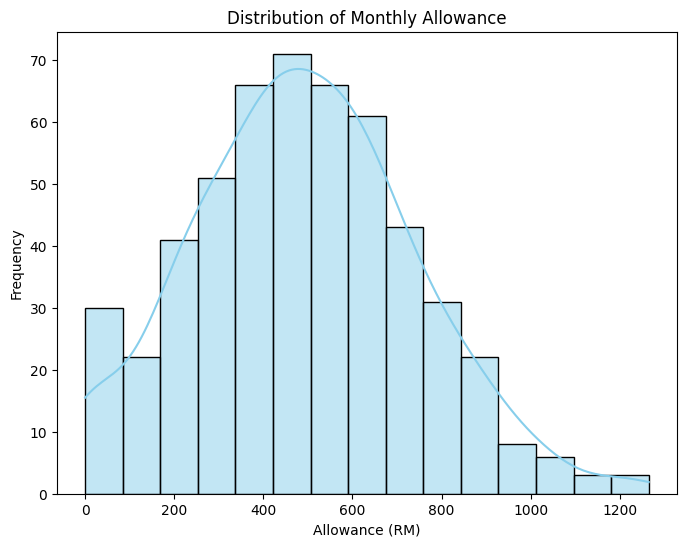

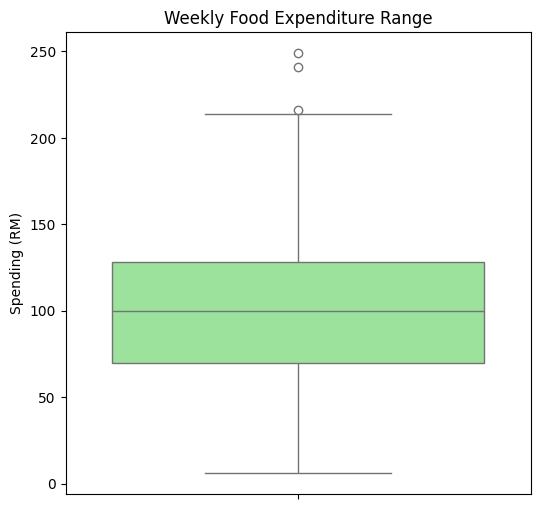

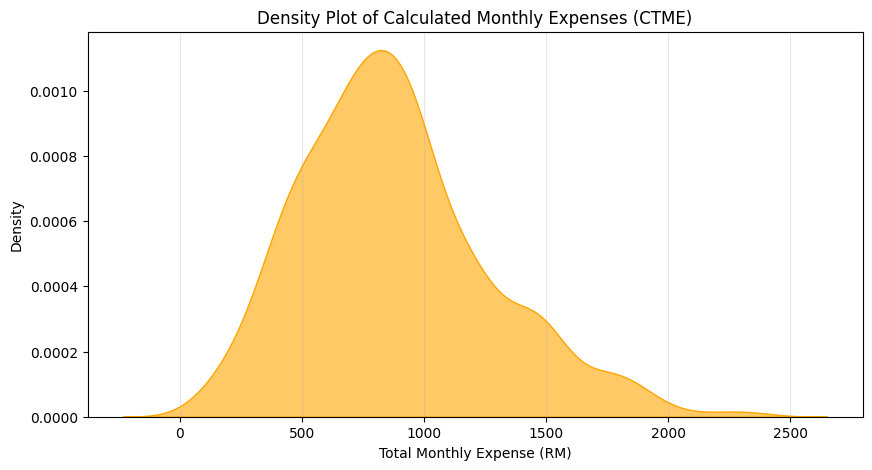

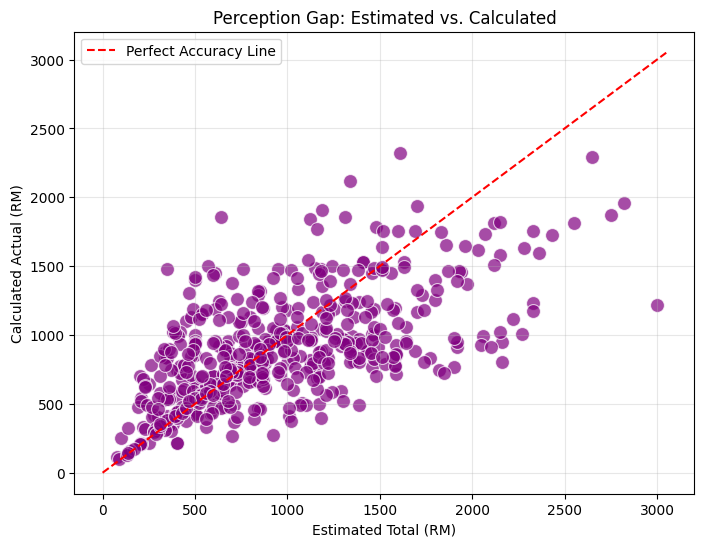

In [204]:

# ==============================================================================
# SECTION 3: THE "AFTER" GRAPHS (Cleaned & Processed)
# ==============================================================================
print("Generating 'AFTER' Graphs...")

# --- AFTER Graph 1: Allowance (Cleaned Label) ---
plt.figure(figsize=(8, 6))
sns.histplot(df['Allowance'], kde=True, color='skyblue')
plt.title('Distribution of Monthly Allowance') # Added clear title
plt.xlabel('Allowance (RM)') # Added clear short label
plt.ylabel('Frequency')

plt.savefig("postprocess_1.png", dpi=300, bbox_inches="tight")
plt.show()


# --- AFTER Graph 2: Food Spending (Cleaned Label) ---
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['FoodWeekly'], color='lightgreen')
plt.title('Weekly Food Expenditure Range')
plt.ylabel('Spending (RM)')

plt.savefig("postprocess_2.png", dpi=300, bbox_inches="tight")
plt.show()


# --- Graph 3: CTME Distribution (Impossible without preprocessing) ---
plt.figure(figsize=(10, 5))
sns.kdeplot(df['CTME'], fill=True, color='orange', alpha=0.6)
plt.title("Density Plot of Calculated Monthly Expenses (CTME)")
plt.xlabel("Total Monthly Expense (RM)")
plt.ylabel("Density")
plt.grid(axis='x', alpha=0.3)
plt.savefig("postprocess_3.png", dpi=300, bbox_inches="tight")
plt.show()


# --- Graph 4: Perception Gap (Impossible without preprocessing) ---
plt.figure(figsize=(8, 6))

sns.scatterplot(x='EstimatedTotal', y='CTME', data=df, s=100, color='purple', alpha=0.7)

# Add Reference Line (Ideal scenario where Estimate = Actual)
limit = max(df['CTME'].max(), df['EstimatedTotal'].max()) + 50
plt.plot([0, limit], [0, limit], 'r--', label='Perfect Accuracy Line')

plt.title('Perception Gap: Estimated vs. Calculated')
plt.xlabel('Estimated Total (RM)')
plt.ylabel('Calculated Actual (RM)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig("postprocess_4.png", dpi=300, bbox_inches="tight")
plt.show()


In [205]:
df.drop(columns=['FoodWeekly'], inplace=True);
df.drop(columns=['TransportWeekly'], inplace=True);

In [206]:
df.drop(columns=['Timestamp'], inplace=True)
df.drop(columns=['AccomPeriod', 'AccomCost'], inplace=True)

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                524 non-null    object 
 1   Year                  524 non-null    object 
 2   Level                 524 non-null    object 
 3   Field                 524 non-null    object 
 4   Living                524 non-null    object 
 5   Scholarship           524 non-null    object 
 6   Loan                  524 non-null    object 
 7   Allowance             524 non-null    int64  
 8   Work                  524 non-null    object 
 9   PartTimeIncome        524 non-null    int64  
 10  Laptop                524 non-null    object 
 11  EatOut                524 non-null    object 
 12  ShopNonEssential      524 non-null    object 
 13  TrackExpenses         524 non-null    object 
 14  Conscious             524 non-null    int64  
 15  AcademicMonthly       5

In [208]:
# The columns that are Yes/No questions
binary_cols = ['Scholarship', 'Loan', 'Work', 'Laptop', 'TrackExpenses']

for col in binary_cols:
    # This looks for "Yes" inside the string (handling "Yes / Ya" automatically)
    df[col] = df[col].astype(str).str.contains('Yes', case=False).astype(int)
    
# Check the results
print(df[binary_cols].head())

   Scholarship  Loan  Work  Laptop  TrackExpenses
0            1     0     1       1              0
1            1     1     0       1              0
2            0     0     0       1              1
3            1     0     0       1              1
4            0     0     0       1              0


In [209]:
# 1. Helper function to clean "Year" and "Level"
def clean_year(val):
    val = str(val)
    if '1' in val: return 1
    if '2' in val: return 2
    if '3' in val: return 3
    if '4' in val: return 4
    return 1 # Fallback or handle as appropriate

def clean_level(val):
    val = str(val).lower()
    if 'diploma' in val: return 1
    if 'degree' in val or 'bachelor' in val: return 2
    if 'master' in val: return 3
    if 'phd' in val: return 4
    return 2 # Fallback

# 2. Helper function to clean Frequency (Never -> Daily)
def clean_frequency(val):
    val = str(val).lower()
    if 'rarely' in val or 'jarang' in val: return 1
    if 'occasionally' in val or 'sometimes' in val or 'kadang' in val: return 2
    if 'frequently' in val or 'often' in val or 'kerap' in val: return 3
    return 2 # Fallback

# APPLY THEM
df['Year'] = df['Year'].apply(clean_year)
df['Level'] = df['Level'].apply(clean_level)
df['EatOut'] = df['EatOut'].apply(clean_frequency)
df['ShopNonEssential'] = df['ShopNonEssential'].apply(clean_frequency)

In [210]:
import pandas as pd

# 1. CLEAN THE TEXT FIRST (Crucial Step)
# We map the long messy strings to short, simple codes.
# This ensures your final columns are named "Male", "Hostel", "Rental", etc.
cleanup_map = {
    # Gender
    'Male / Lelaki': 'Male',
    'Female / Perempuan': 'Female',
    
    # Living
    'On-campus hostel / Asrama dalam kampus': 'Hostel',
    'Off-campus rented house / Rumah sewa luar kampus': 'Rental',
    'With family / Tinggal bersama keluarga': 'Family',
    
    # Field
    'Computer Science / Sains Komputer': 'CS',
    'Others / Lain-lain': 'OtherField',
    'Agriculture / Pertanian': 'Agriculture'
}

# Apply the cleaning (Use replace to be safe)
cols_to_clean = ['Gender', 'Living', 'Field']
for col in cols_to_clean:
    # This replaces the long text with the short text defined above
    df[col] = df[col].replace(cleanup_map)

dummies = []
nominal_cols = ['Gender', 'Living', 'Field']

for col in nominal_cols:
    # get_dummies on a single Series creates columns named after the values
    # drop_first=True prevents the "Dummy Variable Trap" (essential for regression)
    dummy = pd.get_dummies(df[col], drop_first=True, dtype=int)
    dummies.append(dummy)

# Concatenate all the new dummy columns to the main dataframe
df = pd.concat([df] + dummies, axis=1)

# Drop the original text columns
df.drop(columns=nominal_cols, inplace=True)

# 3. VERIFY
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  524 non-null    int64  
 1   Level                 524 non-null    int64  
 2   Scholarship           524 non-null    int64  
 3   Loan                  524 non-null    int64  
 4   Allowance             524 non-null    int64  
 5   Work                  524 non-null    int64  
 6   PartTimeIncome        524 non-null    int64  
 7   Laptop                524 non-null    int64  
 8   EatOut                524 non-null    int64  
 9   ShopNonEssential      524 non-null    int64  
 10  TrackExpenses         524 non-null    int64  
 11  Conscious             524 non-null    int64  
 12  AcademicMonthly       524 non-null    int64  
 13  InternetMonthly       524 non-null    int64  
 14  EstimatedTotal        524 non-null    int64  
 15  AccommodationMonthly  5

In [211]:
# Check info - Dtype should contain ONLY int64 or float64
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  524 non-null    int64  
 1   Level                 524 non-null    int64  
 2   Scholarship           524 non-null    int64  
 3   Loan                  524 non-null    int64  
 4   Allowance             524 non-null    int64  
 5   Work                  524 non-null    int64  
 6   PartTimeIncome        524 non-null    int64  
 7   Laptop                524 non-null    int64  
 8   EatOut                524 non-null    int64  
 9   ShopNonEssential      524 non-null    int64  
 10  TrackExpenses         524 non-null    int64  
 11  Conscious             524 non-null    int64  
 12  AcademicMonthly       524 non-null    int64  
 13  InternetMonthly       524 non-null    int64  
 14  EstimatedTotal        524 non-null    int64  
 15  AccommodationMonthly  5

In [212]:
# Set option to display all columns (None means unlimited)
pd.set_option('display.max_columns', None)

# Now, df.head() will show all columns
print(df.head(5))

   Year  Level  Scholarship  Loan  Allowance  Work  PartTimeIncome  Laptop  \
0     2      1            1     0          0     1             360       1   
1     3      2            1     1          0     0               0       1   
2     2      1            0     0        200     0               0       1   
3     1      1            1     0        300     0               0       1   
4     3      2            0     0        500     0               0       1   

   EatOut  ShopNonEssential  TrackExpenses  Conscious  AcademicMonthly  \
0       1                 2              0          4               10   
1       3                 2              0          5                5   
2       1                 2              1          5                0   
3       2                 1              1          5               50   
4       1                 2              0          4               50   

   InternetMonthly  EstimatedTotal  AccommodationMonthly  FoodMonthly  \
0            

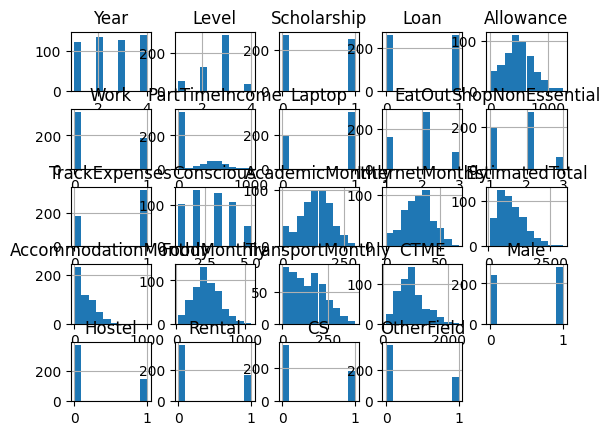

In [213]:
# histograms
df.hist()
plt.show()

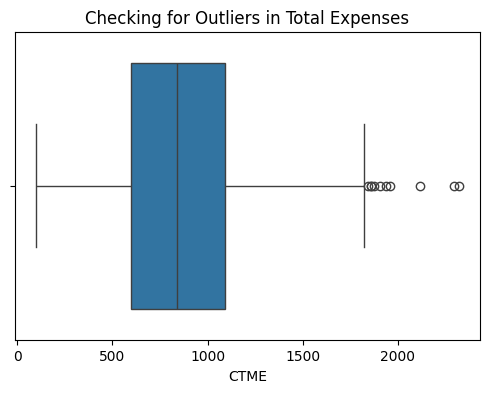

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the Target Variable (CTME) to see if anyone is way off
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['CTME'])
plt.title("Checking for Outliers in Total Expenses")
plt.show()

In [215]:
# Calculate the "Fence" to find outliers
Q1 = df['CTME'].quantile(0.25)
Q3 = df['CTME'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds (standard is 1.5 times IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outlier rows
outliers = df[(df['CTME'] < lower_bound) | (df['CTME'] > upper_bound)]
print(f"🗑️ Removing {len(outliers)} outlier(s):")
print(outliers[['CTME']])

# Filter the dataframe to keep only GOOD rows
df = df[(df['CTME'] >= lower_bound) & (df['CTME'] <= upper_bound)]

print(f"✅ New dataset size: {len(df)} rows")

🗑️ Removing 10 outlier(s):
        CTME
42   2294.64
47   1858.20
74   1875.11
165  1907.09
203  2318.89
316  2117.35
399  1937.72
457  1957.11
483  1840.83
499  1860.12
✅ New dataset size: 514 rows


In [216]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forbidden = ['CTME', 'EstimatedTotal', 'AccommodationMonthly', 'FoodMonthly', 'TransportMonthly', 'InternetMonthly', 'AcademicMonthly']

# 1. Define your Features (X) and Target (y)
# Drop the target columns from X so the model doesn't cheat!
# We also drop 'EstimatedTotal' because that's just the student's guess
y = df['CTME']
X = df.drop(columns=forbidden)

# 2. Split into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

print("✅ Model trained successfully!")

train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

print(f"---DATA TRAIN--")
print(f"📉 MAE  (Mean Absolute Error): RM {train_mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {train_rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {train_r2:.4f}")


predictions = model.predict(X_test)

# 1. Calculate the metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) # RMSE is just the square root of MSE
r2 = r2_score(y_test, predictions)

# 2. Print them clearly
print(f"---DATA TEST--")
print(f"📉 MAE  (Mean Absolute Error): RM {mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {r2:.4f}")

# This will be the baseline

✅ Model trained successfully!
---DATA TRAIN--
📉 MAE  (Mean Absolute Error): RM 131.93
💥 RMSE (Root Mean Sq Error): RM 169.51
📊 R²   (Fit Score 0-1):      0.7772
---DATA TEST--
📉 MAE  (Mean Absolute Error): RM 153.25
💥 RMSE (Root Mean Sq Error): RM 201.92
📊 R²   (Fit Score 0-1):      0.6742


In [217]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Scale
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Train
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)


train_pred = model_scaled.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

print(f"Feature Scaling Results:")
print(f"---DATA TRAIN--")
print(f"📉 MAE  (Mean Absolute Error): RM {train_mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {train_rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {train_r2:.4f}")

# 4. Predict
preds_scaled = model_scaled.predict(X_test_scaled)

# 5. Get Metrics (FIXED HERE)
mae_scaled = mean_absolute_error(y_test, preds_scaled)
mse_scaled = mean_squared_error(y_test, preds_scaled) # Get MSE first
rmse_scaled = np.sqrt(mse_scaled)                     # Calculate RMSE manually
r2_scaled = r2_score(y_test, preds_scaled)

print(f"---DATA TEST--")
print(f"MAE:  RM {mae_scaled:.2f}")
print(f"RMSE: RM {rmse_scaled:.2f}")
print(f"R²:   {r2_scaled:.4f}")

Feature Scaling Results:
---DATA TRAIN--
📉 MAE  (Mean Absolute Error): RM 131.93
💥 RMSE (Root Mean Sq Error): RM 169.51
📊 R²   (Fit Score 0-1):      0.7772
---DATA TEST--
MAE:  RM 153.25
RMSE: RM 201.92
R²:   0.6742


In [218]:
# Check correlations again, ignoring the "Cheating" columns
corrs = df.corr()['CTME'].sort_values(ascending=False)
valid_corrs = corrs.drop(labels=forbidden, errors='ignore')

print("Top Valid Predictors:")
print(valid_corrs.head(20))

Top Valid Predictors:
Allowance           0.672946
ShopNonEssential    0.660972
Rental              0.630579
EatOut              0.628488
Laptop              0.090021
Work                0.059564
Scholarship         0.051119
PartTimeIncome      0.043674
Loan                0.043447
CS                  0.017927
OtherField          0.000773
Level              -0.010718
Male               -0.024420
Year               -0.028998
Hostel             -0.135562
TrackExpenses      -0.286636
Conscious          -0.471094
Name: CTME, dtype: float64


In [219]:
# 1. Select ONLY the best features 
# (Based on your valid_corrs output earlier)
features_selected = [
    'ShopNonEssential', 
    'Allowance', 
    'Hostel', 
    'Rental',
    'EatOut', 
    'Laptop', 
    'TrackExpenses', 
    'Conscious'
]

X_sel = df[features_selected]
y_sel = df['CTME']

# 2. Split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.2, random_state=42)

train_df = X_train_sel.copy()
train_df['CTME'] = y_train_sel
train_df.to_csv('split_dataset_train.csv', index=False)

test_df = X_test_sel.copy()
test_df['CTME'] = y_test_sel
test_df.to_csv('split_dataset_test.csv', index=False)

print("✅ Saved 'split_dataset_train.csv' and 'split_dataset_test.csv'")

# 3. Train
model_sel = LinearRegression()
model_sel.fit(X_train_sel, y_train_sel)

print(f"\nFeature Selection Results:")
train_pred = model_sel.predict(X_train_sel)
train_mae = mean_absolute_error(y_train_sel, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_sel, train_pred))
train_r2 = r2_score(y_train_sel, train_pred)

print(f"---DATA TRAIN--")
print(f"📉 MAE  (Mean Absolute Error): RM {train_mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {train_rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {train_r2:.4f}")

# 4. Predict
preds_sel = model_sel.predict(X_test_sel)

# 5. Metrics (FIXED HERE)
mae_sel = mean_absolute_error(y_test_sel, preds_sel)
mse_sel = mean_squared_error(y_test_sel, preds_sel)
rmse_sel = np.sqrt(mse_sel)
r2_sel = r2_score(y_test_sel, preds_sel)

print(f"---DATA TEST--")
print(f"📉 MAE  (Mean Absolute Error): RM {mae_sel:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {rmse_sel:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {r2_sel:.4f}")

✅ Saved 'split_dataset_train.csv' and 'split_dataset_test.csv'

Feature Selection Results:
---DATA TRAIN--
📉 MAE  (Mean Absolute Error): RM 132.27
💥 RMSE (Root Mean Sq Error): RM 171.46
📊 R²   (Fit Score 0-1):      0.7721
---DATA TEST--
📉 MAE  (Mean Absolute Error): RM 154.20
💥 RMSE (Root Mean Sq Error): RM 203.52
📊 R²   (Fit Score 0-1):      0.6691


In [220]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Define model & params
param_grid = {'alpha': [0.1, 1.0, 10, 50, 100]}
ridge = Ridge()

# 2. Setup Grid Search
# Note: scoring='neg_mean_absolute_error' tries to minimize MAE
grid_search = GridSearchCV(ridge, param_grid, cv=2, scoring='neg_mean_absolute_error')

# 3. Fit on the SELECTED features (from your Step 2)
grid_search.fit(X_train_sel, y_train_sel)

# 4. Get best model
best_model = grid_search.best_estimator_
print(f"Best Alpha found: {grid_search.best_params_}")



print(f"\nHyperparameter Tuning Results:")
train_pred = best_model.predict(X_train_sel)
train_mae = mean_absolute_error(y_train_sel, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_sel, train_pred))
train_r2 = r2_score(y_train_sel, train_pred)

print(f"---DATA TRAIN--")
print(f"📉 MAE  (Mean Absolute Error): RM {train_mae:.2f}")
print(f"💥 RMSE (Root Mean Sq Error): RM {train_rmse:.2f}")
print(f"📊 R²   (Fit Score 0-1):      {train_r2:.4f}")


# 5. Predict
preds_tuned = best_model.predict(X_test_sel)

# 6. Metrics (The Fix is here!)
mae_tuned = mean_absolute_error(y_test_sel, preds_tuned)


mse_tuned = mean_squared_error(y_test_sel, preds_tuned)
rmse_tuned = np.sqrt(mse_tuned)

r2_tuned = r2_score(y_test_sel, preds_tuned)

print(f"---DATA TEST--")
print(f"MAE:  RM {mae_tuned:.2f}")
print(f"RMSE: RM {rmse_tuned:.2f}")
print(f"R²:   {r2_tuned:.4f}")

Best Alpha found: {'alpha': 1.0}

Hyperparameter Tuning Results:
---DATA TRAIN--
📉 MAE  (Mean Absolute Error): RM 132.29
💥 RMSE (Root Mean Sq Error): RM 171.48
📊 R²   (Fit Score 0-1):      0.7720
---DATA TEST--
MAE:  RM 153.98
RMSE: RM 203.06
R²:   0.6705


In [221]:
from sklearn.pipeline import Pipeline

# 1. Use ONLY your Best Features
X_final = df[features_selected]
y_final = df['CTME']

# 2. Split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# 3. Create a Pipeline 
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0)) 
])

# 4. Train
pipeline.fit(X_train_f, y_train_f)

# 5. Predict
preds_final = pipeline.predict(X_test_f)

# 6. Score
print(f"FINAL COMBINED SCORE:")
print(f"MAE: RM {mean_absolute_error(y_test_f, preds_final):.2f}")
print(f"RMSE: RM {np.sqrt(mean_squared_error(y_test_f, preds_final)):.2f}")
print(f"R²:  {r2_score(y_test_f, preds_final):.4f}")

FINAL COMBINED SCORE:
MAE: RM 154.11
RMSE: RM 203.40
R²:  0.6695


In [222]:
import joblib

# 1. Create a dictionary to save both the model and the feature names
model_data = {
    "model": pipeline,        
    "features": features_selected 
}

# 2. Save it to a file
joblib.dump(model_data, "student_spending_model.pkl")

print("✅ Model saved as 'student_spending_model.pkl'")

✅ Model saved as 'student_spending_model.pkl'


In [224]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# --- LOAD MODEL ---
try:
    model_data = joblib.load("student_spending_model.pkl")
    model = model_data["model"]
    feature_names = model_data["features"]
except FileNotFoundError:
    st.error("Model file not found. Please train the model first!")
    st.stop()

st.set_page_config(page_title="Student Expense Predictor", page_icon="💸")

st.title("💸 Student Expense Predictor")
st.write("Predicts expenses based on these selected features!")

# --- SIDEBAR / INPUTS ---
with st.form("input_form"):
    col1, col2 = st.columns(2)
    
    with col1:
        # 1. Allowance
        allowance = st.number_input("Monthly Allowance from Parents/Guardians (RM)", min_value=0, value=300, step=50)
        
        # Living Arrangement
        living_options = ["With Family", "On-Campus Hostel", "Off-Campus Rental"]
        living = st.selectbox("Living Arrangement", living_options)
        
        # Shopping Frequency
        shop_map = {"Rarely": 0, "Occasionally": 1, "Frequently": 2}
        shop = st.selectbox("Shopping Frequency for Non-Essential", list(shop_map.keys()))
        shop_val = shop_map[shop]

        # Eating Out
        eat_map = {"Rarely": 0, "Sometimes": 1, "Often (daily)": 2}
        eat = st.selectbox("Eating Out Frequency", list(eat_map.keys()))
        eat_val = eat_map[eat]

    with col2:

          
        # Laptop
        laptop = st.radio("Do you own a laptop?", ["No", "Yes"])
        laptop_val = 1 if laptop == "Yes" else 0

        # Tracking
        track = st.radio("Do you track expenses?", ["No", "Yes"])
        track_val = 1 if track == "Yes" else 0
        
        # Consciousness
        conscious = st.slider("Financial Discipline (1-5)", 1, 5, 3)

    submit = st.form_submit_button("Predict Expenses")

# --- PREDICTION ---
if submit:
    is_hostel = 1 if living == "On-Campus Hostel" else 0
    is_rental = 1 if living == "Off-Campus Rental" else 0
    
    # Create Data Row
    input_data = {
        'ShopNonEssential': shop_val,
        'Allowance': allowance,
        'Hostel': is_hostel,
        'Rental': is_rental,
        'EatOut': eat_val,
        'Laptop': laptop_val,
        'TrackExpenses': track_val,
        'Conscious': conscious
    }
    
    # Convert to DF
    input_df = pd.DataFrame([input_data])
    input_df = input_df[feature_names] # Ensure order
    
    # Predict
    pred = model.predict(input_df)[0]
    
    # Result
    st.divider()
    st.success(f"💰 Predicted Monthly Expenses: **RM {pred:,.2f}**")
    

Overwriting app.py
